# Dog Breed Classification

## this kernel is about how to get the best out of the Xception and InceptionV3 pretrained weights using different ensembling methods

In [22]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense
from keras.utils.data_utils import Sequence
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3

from keras.applications.xception import preprocess_input as xception_preprocessor
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocessor
from keras.applications.inception_v3 import InceptionV3


### Data Exploration

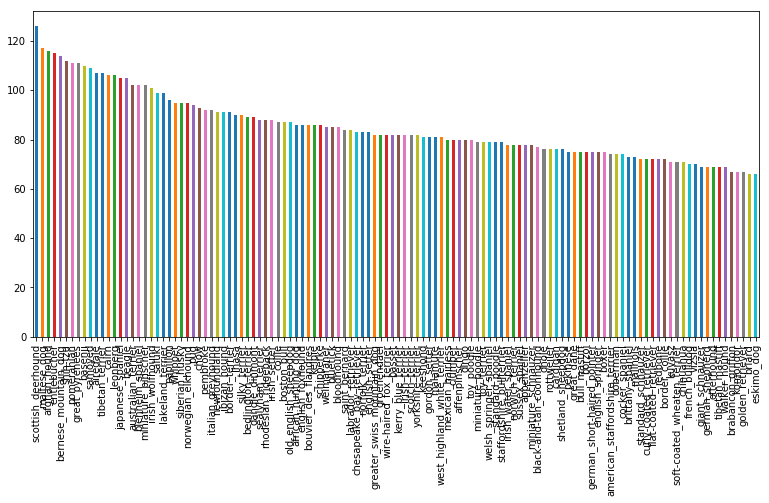

['afghan_hound', 'airedale', 'basenji', 'beagle', 'bernese_mountain_dog', 'cairn', 'entlebucher', 'great_pyrenees', 'japanese_spaniel', 'leonberg', 'maltese_dog', 'pomeranian', 'samoyed', 'scottish_deerhound', 'shih-tzu', 'tibetan_terrier']


In [3]:
LABELS = r"C:\Users\HP\Desktop\labels.csv"

train_df = pd.read_csv(LABELS)
#return top 16 value counts and convert into list
plt.figure(figsize=(13, 6))
train_df['breed'].value_counts().plot(kind='bar')
plt.show()

top_breeds = sorted(list(train_df['breed'].value_counts().head(16).index))
train_df = train_df[train_df['breed'].isin(top_breeds)]

print(top_breeds)

### Train and Validation

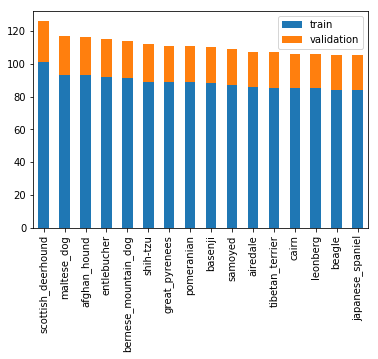

In [4]:
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split

SEED = 1234

TRAIN_FOLDER = r"C:\Users\HP\Desktop\train/"
TEST_FOLDER =  r"C:\Users\HP\Desktop\test/"

DIM = 299

train_df['image_path'] = train_df.apply( lambda x: ( TRAIN_FOLDER + x["id"] + ".jpg" ), axis=1 )

train_data = np.array([ img_to_array(load_img(img, target_size=(DIM, DIM))) for img in train_df['image_path'].values.tolist()]).astype('float32')
train_labels = train_df['breed']
x_train, x_validation, y_train, y_validation = train_test_split(train_data, train_labels, test_size=0.2, stratify=np.array(train_labels), random_state=SEED)

#calculate the value counts for train and validation data
data = y_train.value_counts().sort_index().to_frame()
data.columns = ['train']
data['validation'] = y_validation.value_counts().sort_index().to_frame()

new_plot = data[['train','validation']].sort_values(['train']+['validation'], ascending=False)
new_plot.plot(kind='bar', stacked=True)
plt.show()

### one hot encoding

In [5]:
# Let's convert our labels into one hot encoded format

y_train = pd.get_dummies(y_train.reset_index(drop=True), columns=top_breeds).as_matrix()
y_validation = pd.get_dummies(y_validation.reset_index(drop=True), columns=top_breeds).as_matrix()

print(y_train[0])

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


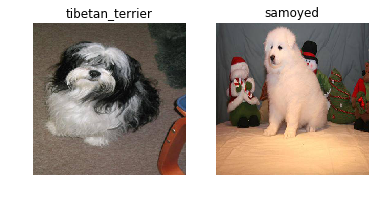

In [6]:
plt.subplot(1, 2, 1)
plt.title(top_breeds[np.where(y_train[5]==1)[0][0]])
plt.axis('off')
plt.imshow(x_train[5].astype(np.uint8))

plt.subplot(1, 2, 2)
plt.title(top_breeds[np.where(y_train[7]==1)[0][0]])
plt.axis('off')
plt.imshow(x_train[7].astype(np.uint8))
plt.show()

### generate botteneck features

In [25]:
from os import makedirs
from os.path import expanduser, exists, join
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
keras.applications.xception.Xception(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
keras.applications.inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
model = ResNet50(weights='imagenet')


cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)
    


102858752/102853048 [==============================] - 452s 4us/step


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

batch_size = 32
epochs = 30
num_classes = len(top_breeds)

def generate_features(model_info, data, labels, datagen):
    print("generating features...")
    datagen.preprocessing_function = model_info["preprocessor"]
    generator = datagen.flow(data, labels, shuffle=False, batch_size=batch_size, seed=model_info["seed"])
    bottleneck_model = model_info["model"](weights='imagenet', include_top=False, input_shape=model_info["input_shape"], pooling=model_info["pooling"])
    return bottleneck_model.predict_generator(generator)

In [ ]:
import time
from keras.utils import Sequence

models = {
    "InceptionV3": {
        "model": InceptionV3,
        "preprocessor": inception_v3_preprocessor,
        "input_shape": (299,299,3),
        "seed": 1234,
        "pooling": "avg"
    },
    "Xception": {
        "model": Xception,
        "preprocessor": xception_preprocessor,
        "input_shape": (299,299,3),
        "seed": 5512,
        "pooling": "avg"
    }
}

for model_name, model in models.items():
    print("Predicting : {}".format(model_name))
    filename = model_name + '_features.npy'
    validfilename = model_name + '_validfeatures.npy'
    if exists(filename):
        features = np.load(filename)
        validation_features = np.load(validfilename)
    else:
        train_datagen = ImageDataGenerator(
                zoom_range = 0.3,
                width_shift_range=0.1,
                height_shift_range=0.1)
        validation_datagen = ImageDataGenerator()
        features = generate_features( model, x_train, y_train, train_datagen)
        validation_features = generate_features(model, x_validation, y_validation, validation_datagen)
        np.save(filename, features)
        np.save(validfilename, validation_features)
        start_time = time.time()
    
    logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
    logreg.fit(features, (y_train * range(num_classes)).sum(axis=1))

    model["predict_proba"] = logreg.predict_proba(validation_features)
    end_time = time.time()
    print('Training time : {} {}'.format(np.round((end_time-start_time)/60, 2),' minutes'))
              

In [ ]:
probas = [ model["predict_proba"] for model_name, model in models.items() ]

avgprobas = np.average(probas, axis=0, weights=[1,1])

print('ensemble validation logLoss : {}'.format(log_loss(y_validation, avgprobas)))

In [ ]:
import tensorflow as tf

with tf.Session() as sess:
    result = sess.run(tf.one_hot(tf.argmax(avgprobas, dimension = 1), depth = 16))
    print('ensemble validation accuracy : {}'.format(accuracy_score(y_validation, result)))

### ensemble by average

### ensemble input features

In [ ]:
features  = np.hstack( [ np.load(model_name + '_features.npy') for model_name, model in models.items() ])
validation = np.hstack( [ np.load(model_name + '_validfeatures.npy') for model_name, model in models.items() ])

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(features, (y_train * range(num_classes)).sum(axis=1))

predict_probs = logreg.predict_proba(validation)

print('ensemble of features va logLoss : {}'.format(log_loss(y_validation, predict_probs)))

In [24]:
import keras

### Accuracy

In [ ]:
with tf.Session() as sess:
    result = sess.run(tf.one_hot(tf.argmax(predict_train, dimension = 1), depth = 16))
    print('ensemble training accuracy : {}'.format(accuracy_score(y_train, result)))

In [ ]:
with tf.Session() as sess:
    result = sess.run(tf.one_hot(tf.argmax(predict_probs, dimension = 1), depth = 16))
    print('ensemble validation accuracy : {}'.format(accuracy_score(y_validation, result)))